<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week3/WISDM_LSTM_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 모델 라이브러리
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings

In [3]:
# 1. 원본 txt 파일 로드 (세미콜론 제거 필요)
# 파일 마지막에 붙은 세미콜론 때문에 에러가 날 수 있어, 먼저 파일을 읽고 처리합니다.
filepath = '/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt'
data = []
with open(filepath, 'r') as f:
    for line in f:
        # 각 줄의 끝에 있는 세미콜론과 공백을 제거하고 쉼표로 분리
        cleaned_line = line.strip().rstrip(';').split(',')
        if len(cleaned_line) == 6: # 데이터가 6개 열로 완전한 경우에만 추가
            data.append(cleaned_line)

# 2. Pandas DataFrame으로 변환 및 컬럼명 지정
columns = ['user', 'activity', 'timestamp', 'x-accel', 'y-accel', 'z-accel']
df = pd.DataFrame(data, columns=columns)

# 3. 데이터 타입 변환 (숫자형으로)
df['x-accel'] = pd.to_numeric(df['x-accel'])
df['y-accel'] = pd.to_numeric(df['y-accel'])
df['z-accel'] = pd.to_numeric(df['z-accel'])

# 4. 정제된 CSV 파일로 저장
df.to_csv('WISDM_ar_v1.1_cleaned.csv', index=False)

print("CSV 파일 변환 및 저장 완료!")
display(df.head())

CSV 파일 변환 및 저장 완료!


,user,activity,timestamp,x-accel,y-accel,z-accel
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [4]:
# timestamp 컬럼은 사용하지 않으므로 삭제합니다.
df.drop(columns=['timestamp'], inplace=True, errors='ignore')
df.dropna(inplace=True)
# 숫자형으로 변환
numeric_cols = ['x-accel', 'y-accel', 'z-accel']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

In [5]:
df.isnull().sum()

,0
user,0
activity,0
x-accel,0
y-accel,0
z-accel,0


In [6]:
# 레이블 인코딩
le = LabelEncoder()
df['activity_encoded'] = le.fit_transform(df['activity'])
NUM_CLASSES = len(le.classes_)
print(f"\n활동 레이블: {le.classes_}")
print(f"클래스 개수: {NUM_CLASSES}")

# 피처 스케일링
scaler = StandardScaler()
feature_cols = ['x-accel', 'y-accel', 'z-accel']
df[feature_cols] = scaler.fit_transform(df[feature_cols])
print("✅ 데이터 전처리 완료")



활동 레이블: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']
클래스 개수: 6
✅ 데이터 전처리 완료


In [7]:
print("\n--- 레이블과 숫자 매핑 결과 ---")
# le.classes_ 배열의 인덱스가 곧 인코딩된 숫자입니다.
for idx, label in enumerate(le.classes_):
    print(f"'{label}' -> {idx}")


--- 레이블과 숫자 매핑 결과 ---
'Downstairs' -> 0
'Jogging' -> 1
'Sitting' -> 2
'Standing' -> 3
'Upstairs' -> 4
'Walking' -> 5


In [8]:
# --- 3. 범주형 데이터 분석 (activity 컬럼) ---
print("\n\n--- 3. 활동(Activity) 데이터 분포 확인 ---")
activity_counts = df['activity'].value_counts()
print("[각 활동별 데이터 개수]")
print(activity_counts)



--- 3. 활동(Activity) 데이터 분포 확인 ---
[각 활동별 데이터 개수]
activity
Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: count, dtype: int64


/tmp/ipython-input-3992636053.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='activity', data=df, order=activity_counts.index, palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N

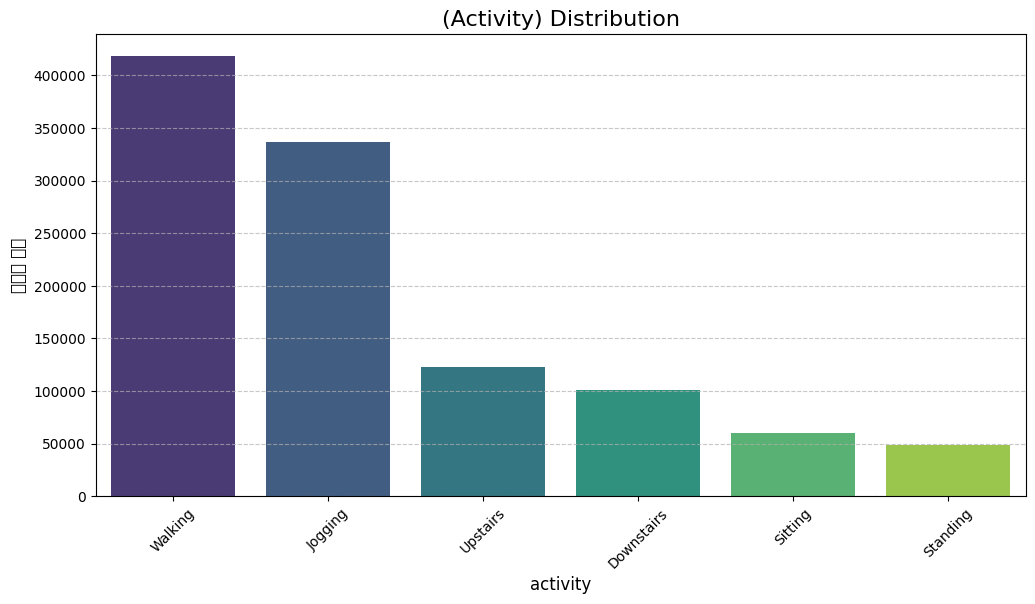

In [9]:
# 활동별 데이터 개수 시각화
plt.figure(figsize=(12, 6))
sns.countplot(x='activity', data=df, order=activity_counts.index, palette='viridis')
plt.title('(Activity) Distribution', fontsize=16)
plt.xlabel('activity', fontsize=12)
plt.ylabel('데이터 개수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
df.drop(columns=['activity'], inplace=True, errors='ignore')
display(df.head())

,user,x-accel,y-accel,z-accel,activity_encoded
0,33,-0.197600,0.806331,0.022317,1
1,33,0.632345,0.596159,0.116722,1
2,33,0.616498,0.539574,-0.100695,1
3,33,-0.185715,1.669250,0.551556,1
4,33,-0.268908,0.721454,1.429807,1


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import warnings

## 2단계: 데이터 조각(세그먼트)별 사용자 정보 기록 (2번 윈도우 생성 단계)
슬라이딩 윈도우로 데이터를 잘라낼 때, 각 조각이 어떤 사용자의 데이터인지도 함께 기록합니다. 이 정보는 groups라는 배열에 저장됩니다.

In [12]:
# --- 2. 슬라이딩 윈도우 생성 (user 정보 포함) ---
print("\n--- 2. 슬라이딩 윈도우 생성 시작 ---")
def create_segments(df, time_steps, step, label_col, feature_cols):
    feature_values = df[feature_cols].values
    label_values = df[label_col].values
    user_values = df['user'].values

    num_segments = len(range(0, len(df) - time_steps, step))
    segments = np.empty((num_segments, time_steps, len(feature_cols)))
    labels = np.empty(num_segments, dtype=int)
    users = np.empty(num_segments, dtype=int)

    idx = 0
    for i in range(0, len(df) - time_steps, step):
        segments[idx] = feature_values[i: i + time_steps]

        label_result = stats.mode(label_values[i: i + time_steps]).mode
        labels[idx] = np.array(label_result).flatten()[0]

        # 세그먼트의 user ID는 동일하므로 첫번째 값을 사용
        users[idx] = user_values[i]

        idx += 1

    return segments, labels, users

Fs = 20
TIME_STEPS = Fs * 4  # 80
STEP_SIZE = Fs * 2   # 40


--- 2. 슬라이딩 윈도우 생성 시작 ---


In [13]:
X, y, groups = create_segments(df, TIME_STEPS, STEP_SIZE, 'activity_encoded', feature_cols)
print(f"✅ 생성된 세그먼트 형태: X={X.shape}, y={y.shape}, groups={groups.shape}")

✅ 생성된 세그먼트 형태: X=(27160, 80, 3), y=(27160,), groups=(27160,)


CNN은 시계열 데이터의 짧은 구간에서 나타나는 국소적인 패턴(예: 발을 내딛는 순간의 충격)을 찾아내는 데 매우 효율적입니다. 합성곱(Convolution)과 풀링(Pooling)을 통해 원본 데이터에서 중요한 특징을 먼저 추출하고, 시퀀스의 길이를 줄여줍니다.

이렇게 처리된 데이터를 LSTM에 전달하면, LSTM은 더 적은 계산량으로 정제된 특징들의 시간 순서에 따른 관계(맥락)를 학습하는 데 집중할 수 있습니다.

In [14]:
# --- 3. CNN-LSTM 모델 정의 ---
class HAR_CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(HAR_CNN_LSTM, self).__init__()
        # CNN Part
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # LSTM Part
        # CNN의 최종 출력 채널(64)이 LSTM의 입력 크기가 됨
        self.lstm = nn.LSTM(input_size=64, hidden_size=100, num_layers=2, batch_first=True)
        self.fc = nn.Linear(100, num_classes)

    def forward(self, x):
        # x shape: (batch, 3, 80)
        out = self.conv_layers(x)
        # out shape: (batch, 64, 20)

        # LSTM 입력을 위해 (배치, 시퀀스, 피처) 형태로 변경
        out = out.permute(0, 2, 1)
        # out shape: (batch, 20, 64)

        out, _ = self.lstm(out)
        # out shape: (batch, 20, 100)

        # 마지막 타임스텝의 출력만 사용
        out = self.fc(out[:, -1, :])
        return out


# 3단계: 사용자 그룹별로 데이터 분할 (4번 교차 검증 단계)
## Subject-wise 방식: 훈련 데이터와 테스트 데이터에 등장하는 사용자가 절대 겹치지 않도록 데이터를 나눕니다.
이 부분이 가장 핵심입니다. sklearn의 GroupKFold는 바로 이 "Subject-wise" 분할을 위해 만들어진 기능입니다.

In [15]:
# --- 4. Subject-wise 교차 검증 ---
print("\n--- 4. Subject-wise 교차 검증 시작 ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

N_SPLITS = 5  # 5-fold 교차 검증
gkf = GroupKFold(n_splits=N_SPLITS)

fold_results = []
fold_accuracies = []  # 각 Fold의 정확도를 저장할 리스트
all_preds = []
all_labels = []



--- 4. Subject-wise 교차 검증 시작 ---
Using device: cuda


In [17]:
# groups 배열을 기준으로 데이터를 나눔
for fold, (train_val_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n========== Fold {fold+1}/{N_SPLITS} ==========")

    # 1. 모델, 손실함수, 옵티마이저 초기화 (매 Fold 마다 새로 생성)
    model = HAR_CNN_LSTM(NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 2. 현재 Fold의 훈련/테스트 데이터 분할
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

    # 훈련 데이터를 다시 훈련 데이터와 검증 데이터로 분할
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val)

    # 3. PyTorch Tensor 및 DataLoader 생성
    # CNN 입력 형태: (배치, 채널, 길이) -> (N, 채널, 길이)로 변경
    X_train = X_train.transpose(0, 2, 1)
    X_val = X_val.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 4. 모델 훈련
    NUM_EPOCHS = 15
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for segments, labels in train_loader:
            segments, labels = segments.to(device), labels.to(device)
            outputs = model(segments)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        running_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for segments, labels in val_loader:
                segments, labels = segments.to(device), labels.to(device)
                outputs = model(segments)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    fold_results.append(history)

    # 5. 모델 평가 및 예측 결과 저장
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for segments, labels in test_loader:
            segments, labels = segments.to(device), labels.to(device)
            outputs = model(segments)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    fold_accuracies.append(accuracy) # 정확도 저장
    print(f'✅ Fold {fold+1} Test Accuracy: {accuracy:.2f} %')


========== Fold 1/5 ==========
Epoch [1/15], Train Loss: 0.6441, Train Acc: 77.39%, Val Loss: 0.3814, Val Acc: 85.96%
Epoch [2/15], Train Loss: 0.3467, Train Acc: 86.68%, Val Loss: 0.2878, Val Acc: 90.00%
Epoch [3/15], Train Loss: 0.2477, Train Acc: 91.24%, Val Loss: 0.2208, Val Acc: 92.24%
Epoch [4/15], Train Loss: 0.1845, Train Acc: 93.62%, Val Loss: 0.1738, Val Acc: 94.03%
Epoch [5/15], Train Loss: 0.1495, Train Acc: 94.72%, Val Loss: 0.1252, Val Acc: 96.24%
Epoch [6/15], Train Loss: 0.1218, Train Acc: 95.96%, Val Loss: 0.1419, Val Acc: 95.32%
Epoch [7/15], Train Loss: 0.1028, Train Acc: 96.51%, Val Loss: 0.0832, Val Acc: 97.34%
Epoch [8/15], Train Loss: 0.0988, Train Acc: 96.55%, Val Loss: 0.0816, Val Acc: 97.06%
Epoch [9/15], Train Loss: 0.0800, Train Acc: 97.24%, Val Loss: 0.0706, Val Acc: 97.52%
Epoch [10/15], Train Loss: 0.0699, Train Acc: 97.74%, Val Loss: 0.0672, Val Acc: 97.57%
Epoch [11/15], Train Loss: 0.0679, Train Acc: 97.76%, Val Loss: 0.0722, Val Acc: 97.48%
Epoch [12


--- 5. 훈련 과정 시각화 ---


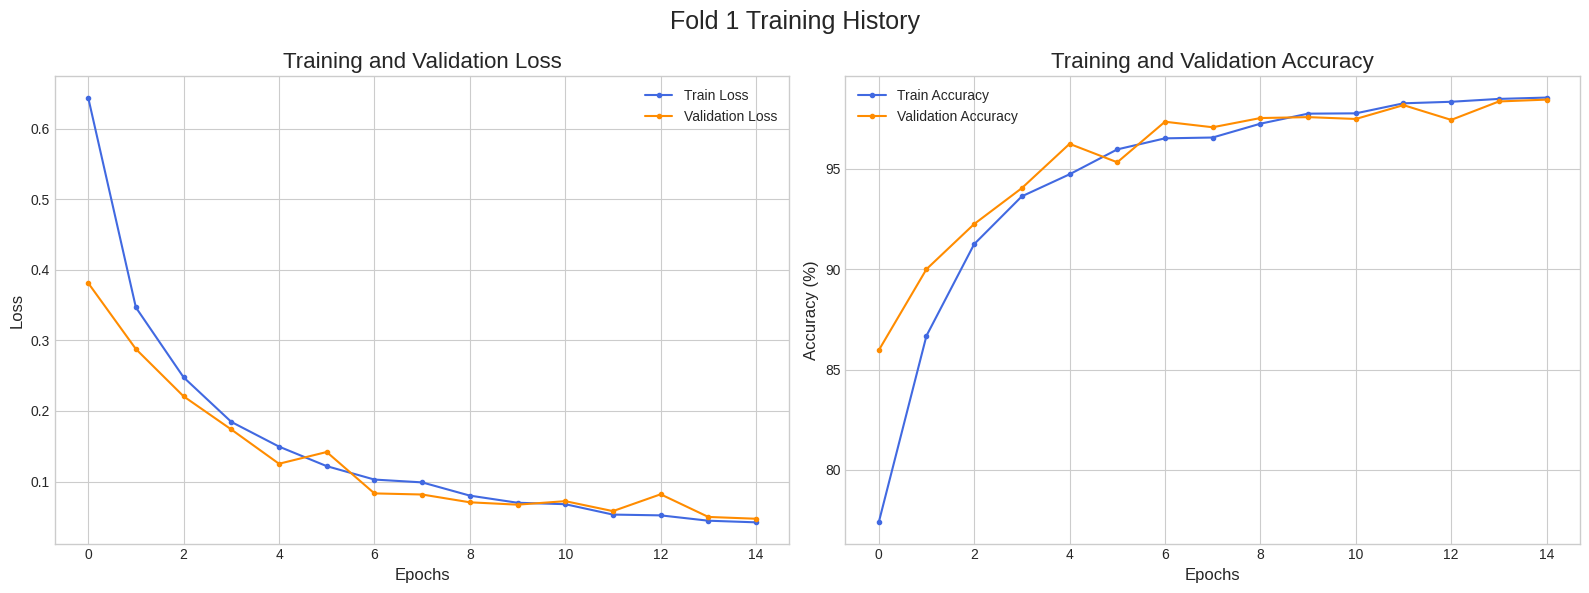

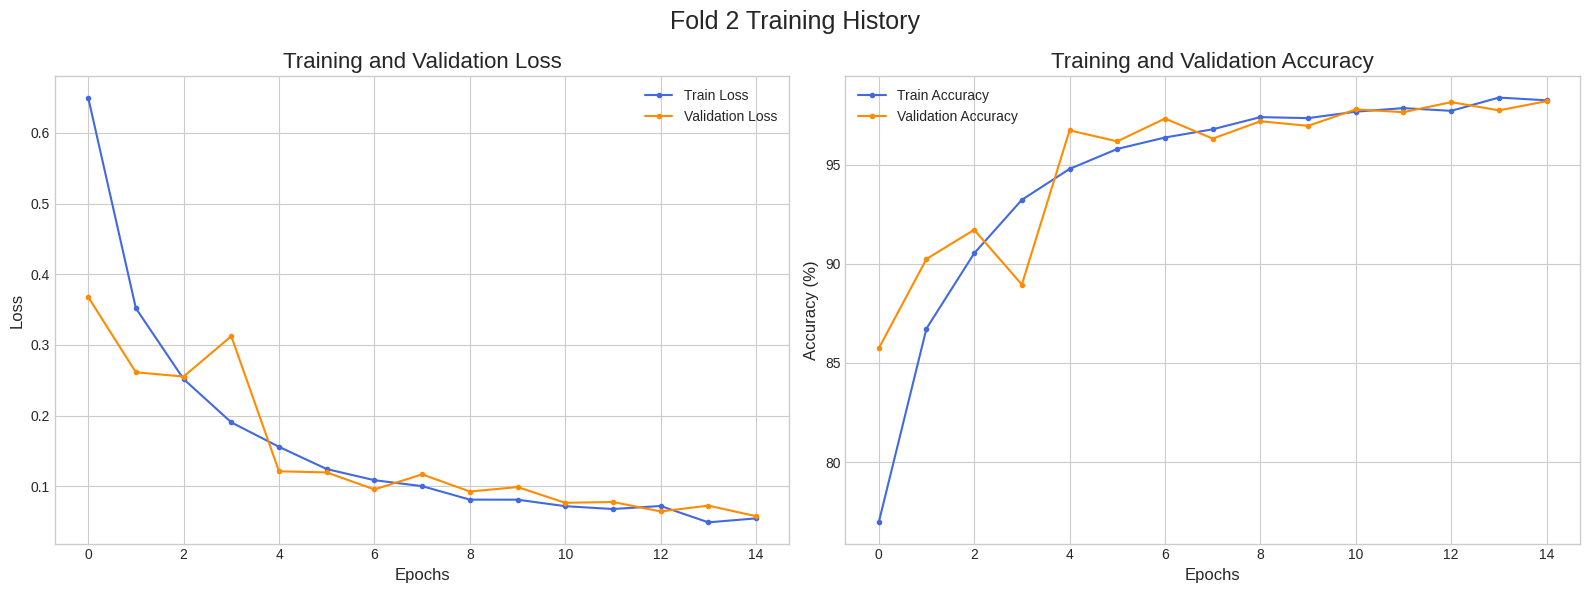

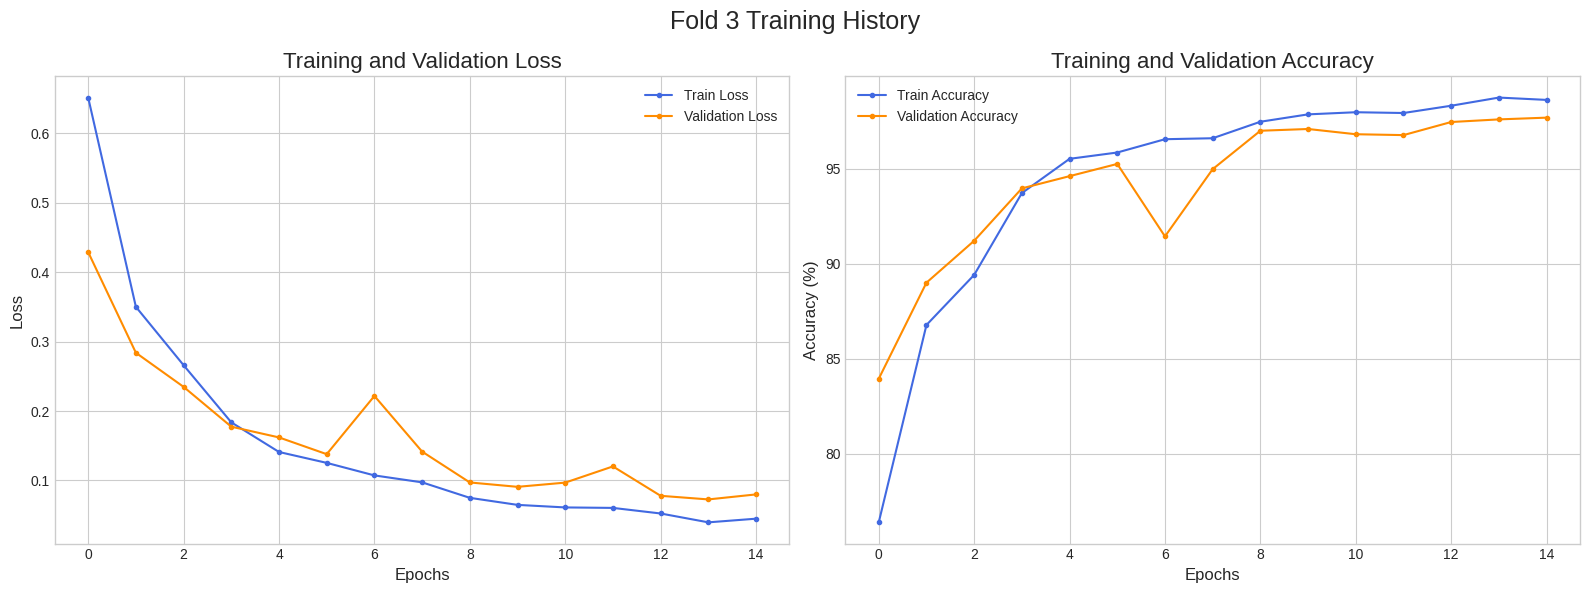

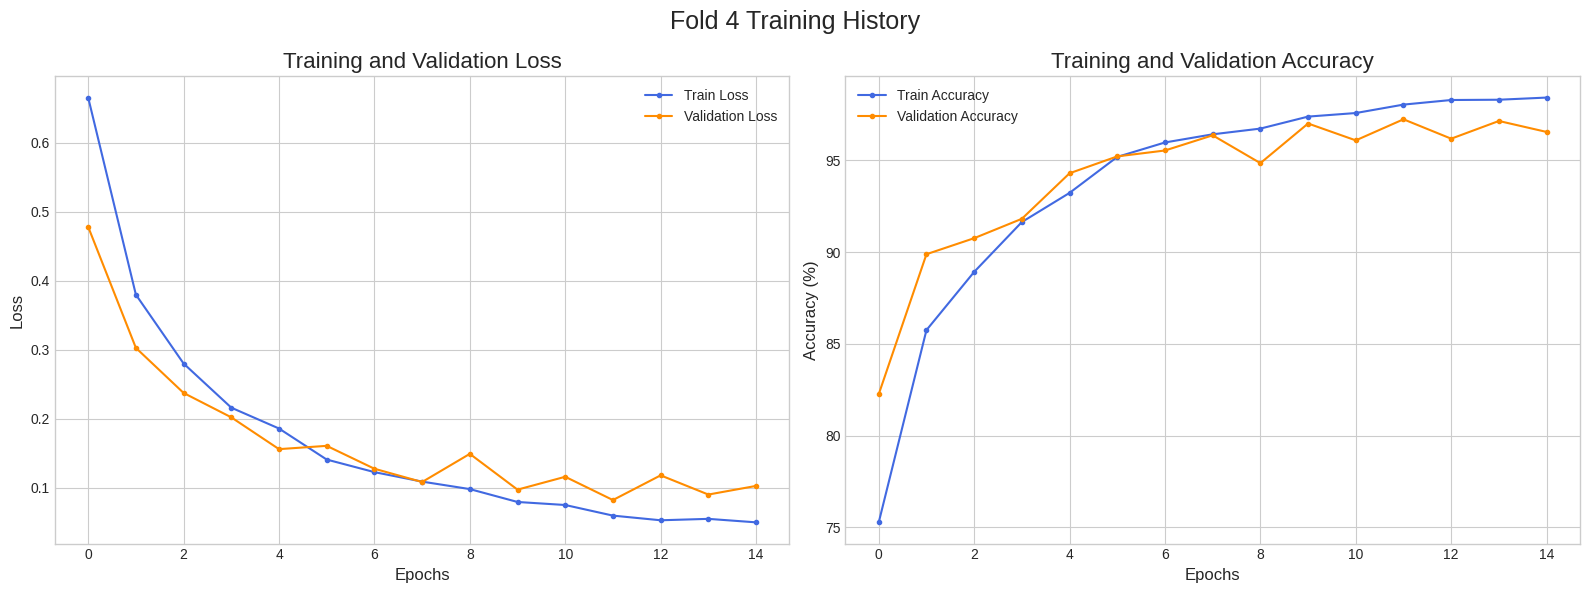

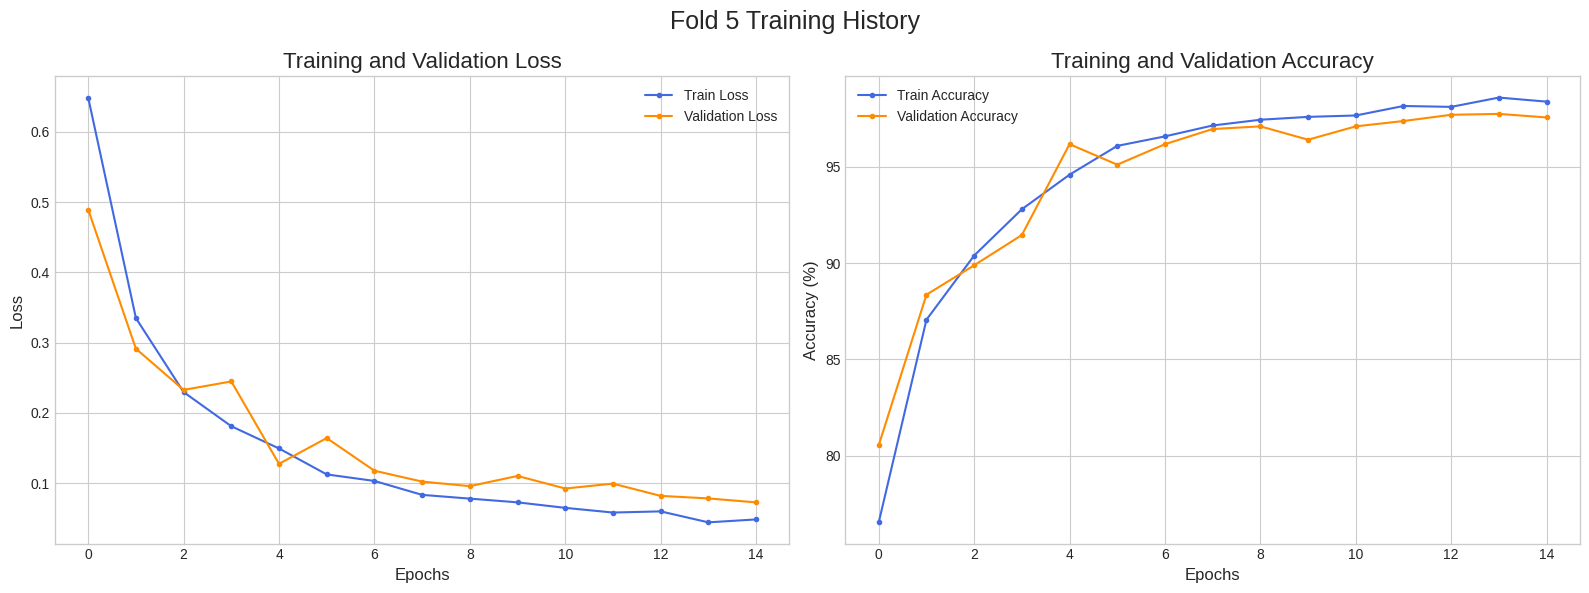

In [18]:
# --- 5. 훈련 과정 시각화 ---
print("\n--- 5. 훈련 과정 시각화 ---")
for i, history in enumerate(fold_results):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Fold {i+1} Training History', fontsize=18)

    ax1.plot(history['train_loss'], label='Train Loss', color='royalblue', marker='o', markersize=3)
    ax1.plot(history['val_loss'], label='Validation Loss', color='darkorange', marker='o', markersize=3)
    ax1.set_title('Training and Validation Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()

    ax2.plot(history['train_acc'], label='Train Accuracy', color='royalblue', marker='o', markersize=3)
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='darkorange', marker='o', markersize=3)
    ax2.set_title('Training and Validation Accuracy', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [19]:
# --- 6. 최종 결과 ---
print("\n\n--- 6. 최종 교차 검증 결과 ---")
accuracies_np = np.array(fold_accuracies)

print(f"각 Fold별 테스트 정확도: {accuracies_np}")
print(f"평균 정확도: {accuracies_np.mean():.2f} %")
print(f"정확도 표준편차: {accuracies_np.std():.2f}")



--- 6. 최종 교차 검증 결과 ---
각 Fold별 테스트 정확도: [88.6676591  83.08485183 83.01713023 94.82248521 87.29151559]
평균 정확도: 87.38 %
정확도 표준편차: 4.35


In [20]:
# --- 7. Classification Report ---
print("\n--- 7. Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=le.classes_))


--- 7. Classification Report ---
              precision    recall  f1-score   support

  Downstairs       0.66      0.75      0.70      2513
     Jogging       0.94      0.94      0.94      8412
     Sitting       0.96      0.87      0.91      1494
    Standing       0.94      0.94      0.94      1211
    Upstairs       0.64      0.74      0.68      3068
     Walking       0.95      0.88      0.91     10462

    accuracy                           0.87     27160
   macro avg       0.85      0.85      0.85     27160
weighted avg       0.88      0.87      0.88     27160




--- 8. Confusion Matrix ---


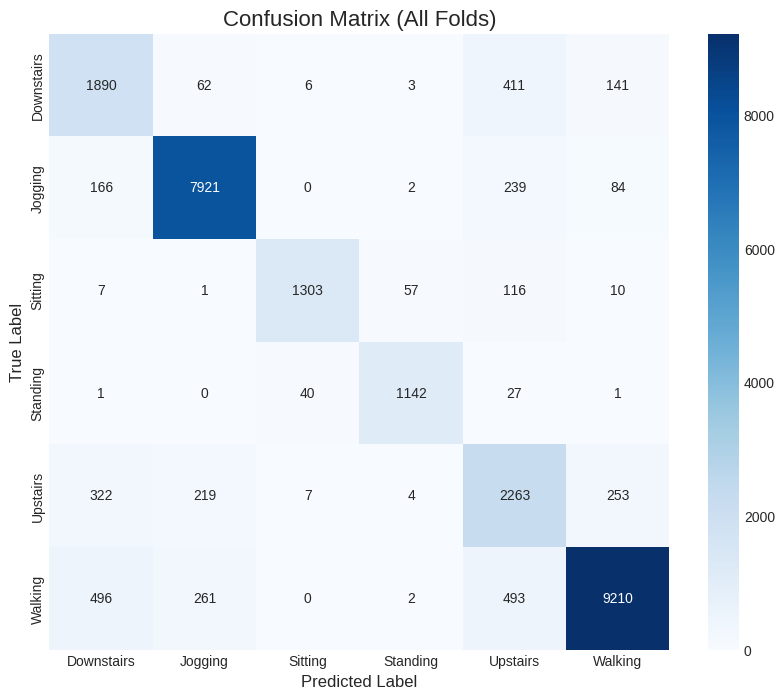

In [21]:
# --- 8. Confusion Matrix ---
print("\n--- 8. Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (All Folds)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()